# Implementation: Multi-Region Active Contours with a Single Level Set Function

*MVA Final Project Minimal Paths and Deformable Models*

*Authors: Emma Bou Hanna & Sebastian Partarrieu*

## Imports and installs

In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd gdrive/MyDrive/MVA/deformable

/content/gdrive/MyDrive/MVA/deformable


In [ ]:
import numpy as np
import scipy
import cv2
import matplotlib.pyplot as plt
import itertools 

In [ ]:
# For Fast Marching
!pip install scikit-fmm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.2/438.2 KB 6.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-fmm: filename=scikit_fmm-2022.8.15-cp39-cp39-linux_x86_64.whl size=271136 sha256=c548371e2b7dda3ce2ecd3558a8e25217daeb65f143b9a6213b4ea84be076363
  Stored in directory: /root/.cache/pip/wheels/0f/f7/df/3ef59bd62c0ac868d6fcc722312886436366d6cd208787c54a
Successfully built scikit-fmm


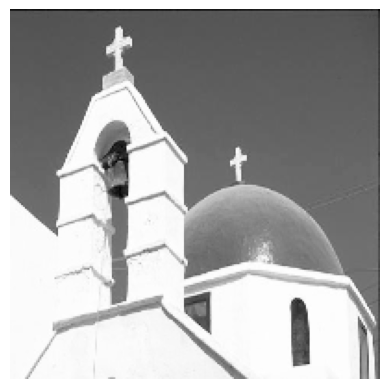

In [ ]:
from PIL import Image
# I = np.array(Image.open("./nt_toolbox/data/cortex.bmp")).astype('uint16')
# I = np.array(Image.open("./images/img_sample.jpg")).astype('uint16')
# I = cv2.cvtColor(I, cv2.COLOR_RGB2GRAY)
I = np.array(Image.open("./images/mosquee.jpg")).astype('uint16')
I = cv2.resize(I, (200, 200))

I = I.astype('float64')
I /= 255.

plt.imshow(I, cmap="Greys_r")
plt.axis("off")
plt.show()

In [ ]:
def load_square():
  I = np.zeros((200,200))
  I = cv2.rectangle(I, (50, 50), (170,170), color=.8, thickness=-1) 
  return I


def load_square_circle():
  I = np.ones((200, 200))*0.2
  I = cv2.rectangle(I, (90, 90), (185,185), color=.95, thickness=-1)
  I = cv2.circle(I, (50, 50), 40, color=.7, thickness=-1)
  return I 

In [ ]:
import cv2
I = load_square_circle()

# I[:110, :] = .7
# I += 0.1

#I = cv2.rectangle(I, (120, 120), (160, 160), color=.5, thickness=-1)

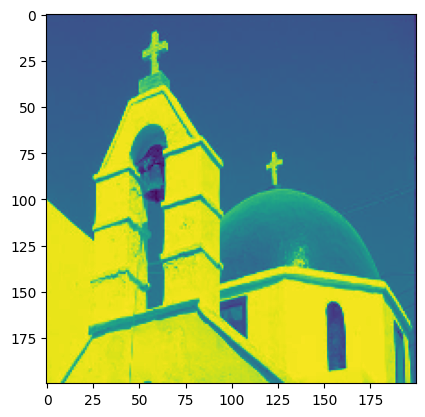

In [ ]:
plt.imshow(I)

## Initial definitions

### Define Regularization energy, such that :
$$g(x) = (1 + ||\nabla (G \star I)||^2)^{-1} $$

where $G$ is a gaussian blur, with unknown kernel size. We took a gaussian filter with sigma=2

In [ ]:
import skfmm as fmm
from nt_toolbox.perform_fast_marching import perform_fast_marching_isotropic
from nt_toolbox.plot_levelset import plot_levelset
from nt_toolbox.div import div
import skimage.measure
import scipy.ndimage

In [ ]:
from nt_toolbox.grad import grad
from scipy.ndimage import gaussian_filter

In [ ]:
def get_contours_regions(regions):
  unique_regions = np.unique(regions)
  new_contours = []
  contour_regions = []

  for comb in list(itertools.combinations(unique_regions, 2)):
    mask1 = (regions == comb[0])
    mask2 = (regions == comb[1])

    comb_mask = np.zeros_like(regions)
    comb_mask[mask1] = 1
    comb_mask[mask2] = -1

    conts = get_contour_eps_levels(comb_mask)

    if conts.any():
      new_contours.append(conts)

      cont_regions = [list(comb) for _ in range(conts.shape[1])]
      contour_regions.append(cont_regions)


  return np.hstack(new_contours).T, np.vstack(contour_regions)

In [ ]:
def get_voronoi_cij(contours, contours_regions, unique_neighbors, shape_vor):
  ## obtain region segments
  Cij = {}

  for neighbors in unique_neighbors:
    mask_ = contours_regions == neighbors
    mask_ = mask_[:, 0] * mask_[:, 1]
    pos_Cij = contours[mask_]
    Cij[tuple(neighbors.astype(int))] = pos_Cij
  
  ## obtain voronoi regions for each region segment using FM
  distance_Cij = {}

  for neighbors, pos_Cij in Cij.items():
    D_ij = perform_fast_marching_isotropic(np.ones(shape_vor), pos_Cij.T)
    distance_Cij[neighbors] = D_ij

  ## voronoi masks
  Distance = np.stack(list(distance_Cij.values()), axis=-1)
  Indices = np.argmin(Distance, axis=-1)
  Voronoi = np.zeros((shape_vor[0], shape_vor[1], 2))

  for i, neigh in enumerate(unique_neighbors):
    Voronoi[Indices == i] = neigh
  
  return Voronoi, Indices

In [ ]:
def compute_freg(Phi, g, eps=1e-15):
  """
  Compute regularizing extended velocity
  """
  grad_phi = grad(Phi, order=2)
  norm_grad_phi = np.sqrt(np.sum(grad_phi**2, 2))
  normalized_gradient = grad_phi/(np.repeat(norm_grad_phi[:,:,np.newaxis],2,axis=-1) + eps)
  normalized_gradient = normalized_gradient*g[:, :, np.newaxis]
  freg = div(normalized_gradient[:,:,0], normalized_gradient[:,:,1],order=2)
  return freg, norm_grad_phi

In [ ]:
def update_Phi(I, Phi, g, regions, unique_regions, Voronoi, unique_neighbors, dt, ci, mu):
  ## Compute extended velocities and new Phi function
  new_phi = np.zeros_like(I)
  freg, norm_grad_phi = compute_freg(Phi, g)
  for idx, reg in enumerate(unique_regions):
    mask_reg = regions == reg
    for neigh in unique_neighbors:
      if neigh[0] == reg or neigh[1] == reg:
        mask_vor = (Voronoi[:,:,0] == neigh[0]) * (Voronoi[:,:,1] == neigh[1])
        mask_inter = mask_reg*mask_vor

        Fi = (I - ci[reg])**2
        Fi = Fi * mask_inter
      
        j = np.setdiff1d(neigh, reg)[0]
        Fj = (I - ci[j])**2
        Fj = Fj * mask_inter

        #new_phi = new_phi + (Phi + dt*(np.abs(Fi - Fj))*norm_grad_phi)*mask_inter
        new_phi = new_phi + (Phi + dt*(Fj - Fi)*norm_grad_phi)*mask_inter
  new_phi = new_phi + mu*freg*norm_grad_phi
  return new_phi, norm_grad_phi

In [ ]:
def get_contour_eps_levels(mask, eps=1e-15):
  n, p = mask.shape
  D = mask.copy()
  #horizontal
  P1 = D[0:(n-1),:]
  P2 = D[1:,:]
  P = ((P1*P2) < 0)
  
  d = abs(P1-P2)
  d[d < eps] = 1
  v1 = abs(P1)/d
  v2 = abs(P2)/d
  Ah = ((np.vstack((P,np.zeros([1,n]))) + np.vstack((np.zeros([1,n]),P))) > 0)
  Vh = np.maximum(np.vstack((v1,np.zeros([1,n]))), np.vstack((np.zeros([1,n]),v2)))
  
  # vertical
  P1 = D[:,0:(p-1)]
  P2 = D[:,1:]
  P = ((P1*P2) < 0)
  
  d = abs(P1-P2)
  d[d < eps] = 1
  v1 = abs(P1)/d
  v2 = abs(P2)/d
  Av = ((np.hstack((P,np.zeros([p,1]))) + np.hstack((np.zeros([p,1]),P))) > 0)
  Vv = np.maximum(np.hstack((v1,np.zeros([p,1]))), np.hstack((np.zeros([p,1]),v2)))
  
  V = np.zeros([n,p])
  I = np.where(Ah > 0)
  V[I] = Vh[I]
  I = np.where(Av > 0)
  V[I] = np.maximum(V[I],Vv[I])
  
  I = np.where(V != 0)
  x,y = I[0],I[1]
  start_points = np.vstack((x,y))

  return start_points

In [ ]:
def get_eps_levels(regions_dilat, unique_regions, new_phi, eps_ls):
  '''
  Get epsilon level sets for dilated regions from new computation
  of the Phi distance function.
  Contours are obtained by taking the border of new_phi <= eps_ls
  '''
  eps_level_sets = {}
  mask_per_reg = {}

  mask_band = (new_phi <= eps_ls)
  mask_band = mask_band - 0.5

  global_ls = get_contour_eps_levels(mask_band)

  global_ls_mask = np.zeros_like(new_phi)
  global_ls_mask[global_ls[0,:], global_ls[1,:]] = 1

  for reg in unique_regions:
    mask_ = global_ls_mask*(regions_dilat == reg)
    mask_per_reg[reg] = mask_
    eps_level_sets[reg] = np.argwhere(mask_)

  return eps_level_sets, global_ls_mask, mask_per_reg

def reduce_masks(mask_per_reg, dilat_size):
  new_masks = {}
  for reg, mask in mask_per_reg.items():
    mask_reduced = skimage.measure.block_reduce(mask, (dilat_size, dilat_size), np.max).astype(bool)
    new_masks[reg] = mask_reduced
  return new_masks

def new_contours_from_eps_levels(eps_level_sets, I_dilat, unique_regions, dilat_size):
  distance_C_eps = {}

  for reg, C_eps in eps_level_sets.items():
    D_ieps = perform_fast_marching_isotropic(np.ones_like(I_dilat), C_eps.T)
    distance_C_eps[reg] = D_ieps

  Distance = np.stack(list(distance_C_eps.values()), axis=-1)
  Indices = np.argmin(Distance, axis=-1)
  Indices_reduced = skimage.measure.block_reduce(Indices, (dilat_size, dilat_size), np.median)

  attrib_regions = Indices_reduced.copy()
  for i, reg in enumerate(unique_regions):
    attrib_regions[Indices_reduced == i] = reg

  return attrib_regions, Indices_reduced, Indices

In [ ]:
def merge_regions(regions, contours_regions, ci, thresh_merge):
  for neigh in np.unique(contours_regions, axis=0):
    if np.abs(ci[neigh[0]] - ci[neigh[1]]) <= thresh_merge:
      print(f"Merging regions {neigh[0]} and {neigh[1]}")
      regions[regions == neigh[1]] = neigh[0]
  return(regions)

In [ ]:
def two_plot(p1, p2):
  plt.figure(figsize=(8,8))
  plt.subplot(1, 2, 1)
  plt.imshow(p1)
  plt.subplot(1, 2, 2)
  plt.imshow(p2)
  plt.show()

def plot_with_borders(p1, p2):
  plt.figure(figsize=(8,8))
  plt.subplot(1, 2, 1)
  plt.imshow(p1)
  plt.subplot(1, 2, 2)
  plt.imshow(p2)
  plt.show()


In [ ]:
def plot_iteration(Phi, Voronoi, Phi_new, regions, regions_new, contours, I, Indices):
  plt.figure(figsize=(10,10))
  plt.subplot(2,3,1)
  plt.imshow(Phi)
  plt.title("Original Phi")
  plt.axis("off")

  plt.subplot(2,3,2)
  plt.imshow(Voronoi[:,:,0]*10 + Voronoi[:,:,1])
  plt.title("Voronoi regions Cij")
  plt.axis("off")

  plt.subplot(2,3,3)
  plt.imshow(Phi_new)
  plt.title("Updated Phi (with extended velocities)")
  plt.axis("off")

  plt.subplot(2,3,4)
  plt.imshow(regions)
  plt.imshow(I, alpha=0.2)
  plt.title("Original Regions")
  plt.axis("off")

  plt.subplot(2,3,5)
  plt.imshow(regions_new)
  plt.scatter(contours[:,1], contours[:,0], c="pink")
  plt.title("New Regions")
  plt.axis("off")


  plt.subplot(2,3,6)
  plt.imshow(Indices)
  plt.title("Indices new regions")
  plt.axis("off")

  plt.show()

In [ ]:
def epsilon_plots(masks_dilated,
                  masks_reduced,
                  regions_dilat,
                  regions_reduced,
                  new_regions_dilat,
                  new_regions_reduced):
  plt.figure(figsize=(10, 10))
  plt.subplot(1, 2, 1)
  plt.title('OLD region NORMAL size')
  plt.imshow(masks_reduced[1.], cmap='magma')
  plt.imshow(masks_reduced[2.], cmap='magma', alpha=.5)
  plt.imshow(regions_reduced, alpha=.5)

  plt.subplot(1, 2, 2)
  plt.title('OLD region DILATED size')
  plt.imshow(masks_dilated[1.], cmap='magma')
  plt.imshow(masks_dilated[2.], cmap='magma', alpha=.5)
  plt.imshow(regions_dilat, alpha=.5)

  plt.show()


  plt.figure(figsize=(10, 10))
  plt.subplot(1, 2, 1)
  plt.title('NEW region NORMAL size')
  plt.imshow(masks_reduced[1.], cmap='magma')
  plt.imshow(masks_reduced[2.], cmap='magma', alpha=.5)
  plt.imshow(new_regions_reduced, alpha=.5)

  plt.subplot(1, 2, 2)
  plt.title('NEW region DILATED size')
  plt.imshow(masks_dilated[1.], cmap='magma')
  plt.imshow(masks_dilated[2.], cmap='magma', alpha=.5)
  plt.imshow(new_regions_dilat, alpha=.5)
  plt.show()

  plt.figure(figsize=(10, 10))
  plt.subplot(1, 2, 1)
  plt.title('COMPARISON regions old & new NORMAL size')
  plt.imshow(masks_reduced[1.], cmap='magma')
  plt.imshow(masks_reduced[2.], cmap='magma', alpha=.5)
  plt.imshow(regions_reduced, alpha=.3)
  plt.imshow(new_regions_reduced, alpha=.3)

  plt.subplot(1, 2, 2)
  plt.title('COMPARISON regions old & new DILATED size')
  plt.imshow(masks_dilated[1.], cmap='magma')
  plt.imshow(masks_dilated[2.], cmap='magma', alpha=.5)
  plt.imshow(regions_dilat, alpha=.3)
  plt.imshow(new_regions_dilat, alpha=.3)
  plt.show()


### Initialize model

We define $(\Omega_i^0)_{1:M}$ initial regions, and an initial contour $C^0$ with such structure : 

$z \in C^0 ⇔ z = [(x_l, x_r), (y_d, y_u)]$ a frontier between two pixels.



In [ ]:
# Parameters
mu = 1
eps = 1e-15
dt = 20
dilat_size = 3
eps_ls = 3*dilat_size

n, p = I.shape

In [ ]:
I.shape

(200, 200)

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(I.ravel()[:, None])

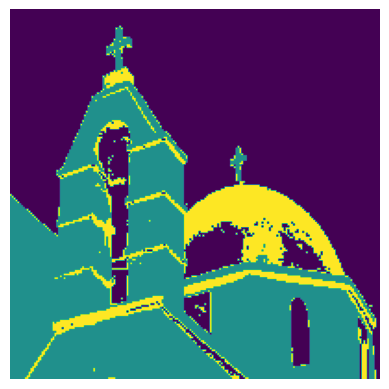

In [ ]:
regions = (1 + (kmeans.predict(I.ravel()[:, None])).reshape(200,200)).astype(float)
regions /= np.max(regions)
plt.imshow(regions)
plt.axis('off')
plt.show()

(-0.5, 199.5, 199.5, -0.5)

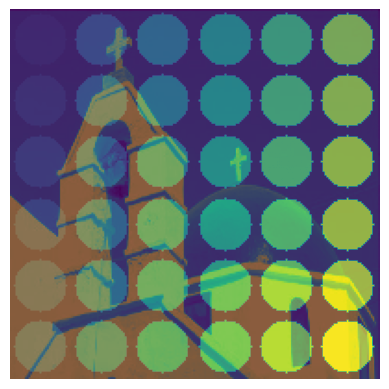

In [ ]:
# Initialization
regions = np.ones_like(I)
# regions = cv2.rectangle(regions, (100, 100), (180,180), color=2, thickness=-1)
# regions = cv2.rectangle(regions, (10, 10), (80, 80), color=3, thickness=-1)
it_regions = 2
n_circles = 6
for i in range(0, n_circles):
  for j in range(0, n_circles):
    regions = cv2.circle(regions, ((n*i)//n_circles + n//(n_circles*2), (n*j)//n_circles + n//(n_circles*2)), n//(n_circles*2 +2), color=it_regions, thickness=-1)
    it_regions += 1

# Initialize with kmeans

unique_regions = np.unique(regions)
plt.imshow(I)
plt.imshow(regions, alpha=.6)
plt.axis("off")

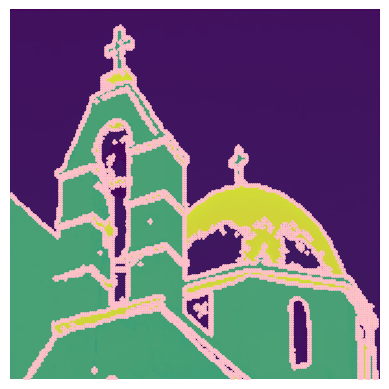

In [ ]:
# initialize contours
contours, contours_regions = get_contours_regions(regions)
plt.imshow(regions)
plt.imshow(I, alpha=.2)
plt.scatter(contours[:,1], contours[:,0], c="pink", s=1)
plt.axis("off")
plt.show()

### Dilate relevant elements for subpixel resolution

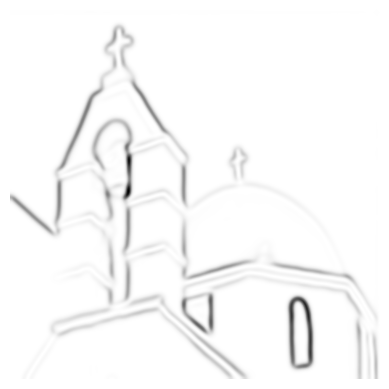

In [ ]:
# Dilate original image for subpixel resolution
I_dilat = scipy.ndimage.zoom(I, dilat_size, order=0)

# Define regularization force in subpixel resolution
g = 1/(1 + np.sum(grad(gaussian_filter(I_dilat, sigma=5), order=2)**2, axis=2))
plt.imshow(g, cmap="Greys_r")
plt.axis("off")
plt.show()


In [ ]:
#initialize Phi
Phi = perform_fast_marching_isotropic(np.ones_like(I_dilat), dilat_size*contours.T)

In [ ]:
it_view = 10
thresh_merge = 0.1

In [ ]:
video_seq = [cv2.addWeighted(regions, 0.7, I, 0.2, 0)]

STEP 1
mean intensities: {0.3333333333333333: 0.3612926003460479, 0.6666666666666666: 0.9596918863864776, 1.0: 0.5765173403648536}
Phi OLD & NEW


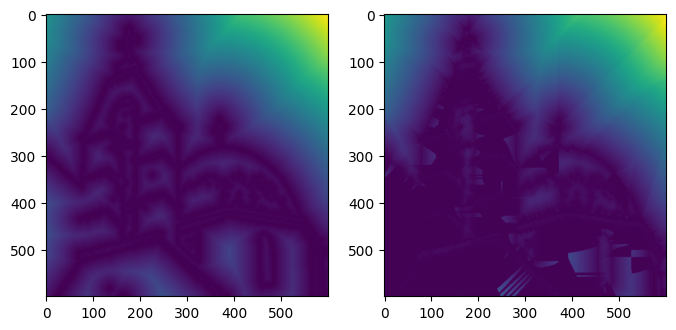

Are Phi different: 356194
--------------
STEP 2
Are regions diff 5659


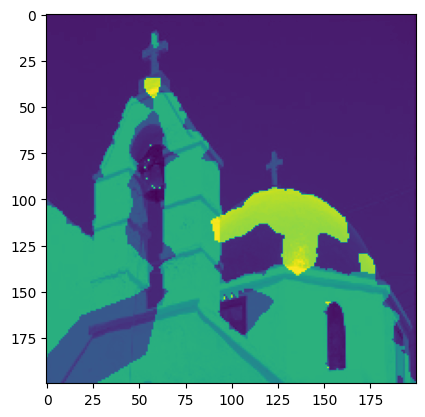

Are regions diff 1955
Are regions diff 1316
Are regions diff 806
Are regions diff 649
Are regions diff 930
Merging regions 0.6666666666666666 and 1.0
Are regions diff 991
Are regions diff 165
Are regions diff 139
Are regions diff 149
STEP 1
mean intensities: {0.3333333333333333: 0.3912386701924196, 0.6666666666666666: 0.9029648205201691}
Phi OLD & NEW


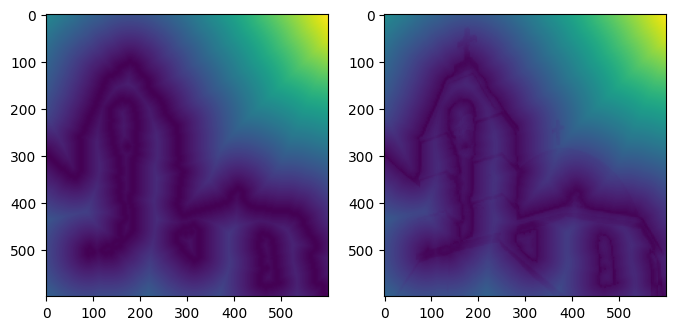

Are Phi different: 358402
--------------
STEP 2
Are regions diff 84


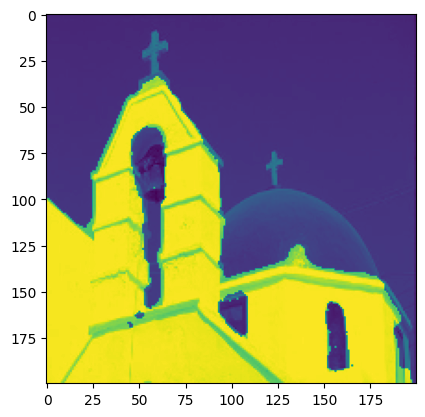

Are regions diff 27
Are regions diff 22
Are regions diff 21
Are regions diff 13
Are regions diff 9
Are regions diff 9
Are regions diff 10
Are regions diff 8
Are regions diff 8
STEP 1
mean intensities: {0.3333333333333333: 0.38960227914506956, 0.6666666666666666: 0.9008005302936146}
Phi OLD & NEW


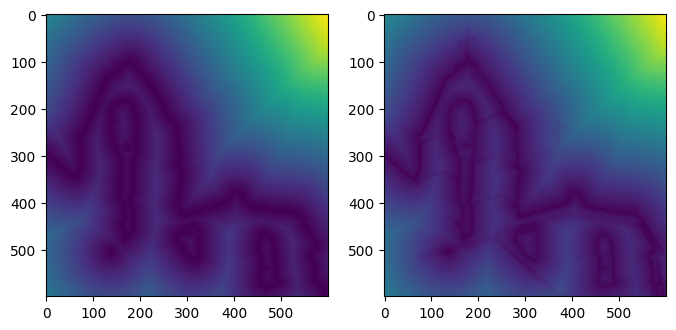

Are Phi different: 358499
--------------
STEP 2
Are regions diff 7


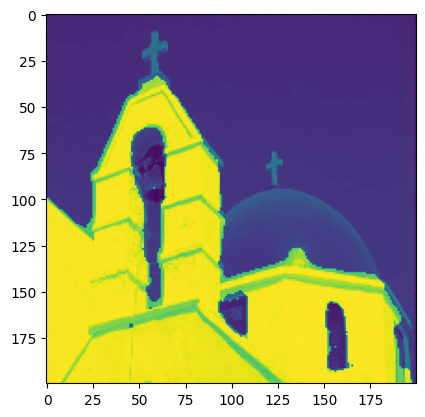

Are regions diff 3
Are regions diff 3
Are regions diff 3
Are regions diff 3
Are regions diff 3
Are regions diff 3
Are regions diff 3
Are regions diff 3
Are regions diff 3
STEP 1
mean intensities: {0.3333333333333333: 0.3895648550060628, 0.6666666666666666: 0.9007300427564351}
Phi OLD & NEW


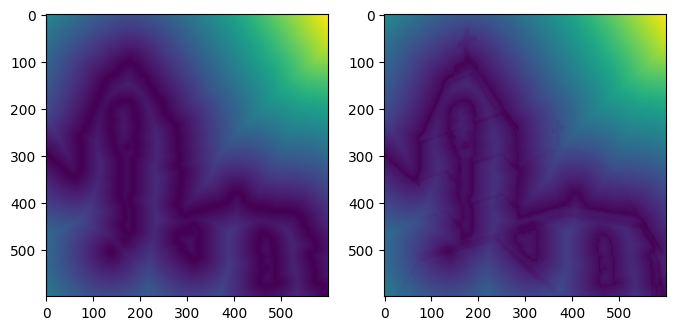

Are Phi different: 358501
--------------
STEP 2
Are regions diff 3


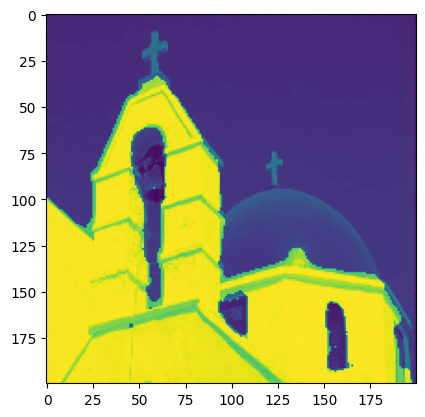

Are regions diff 3
Are regions diff 3
Are regions diff 3
Are regions diff 3
Are regions diff 3


KeyboardInterrupt: ignored

In [ ]:
n_iter = 200
for it in range(n_iter):

  #### STEP 1
  # Get unique regions
  unique_regions = np.unique(regions)
  
  # Get mean intensity per region
  ci = {}
  for i in unique_regions:
    ci[i] = np.mean(I[regions == i])

  if it % it_view == 0:
    print('STEP 1')
    print(f'mean intensities: {ci}')
    
  # Dilate original regions
  regions_dilat = scipy.ndimage.zoom(regions, dilat_size, order=0)
  contours_dilat, contours_regions_dilat = get_contours_regions(regions_dilat)

  # Get Voronoi regions from C_ij
  unique_neighbors = np.unique(contours_regions, axis=0)
  Voronoi, _ = get_voronoi_cij(contours_dilat, contours_regions_dilat, unique_neighbors, shape_vor=I_dilat.shape)

  # Compute new Phi (thanks to extended velocity)
  Phi_new, norm_grad_phi = update_Phi(I_dilat, Phi, g, regions_dilat, unique_regions, Voronoi, unique_neighbors, dt, ci, mu)

  if it % it_view == 0:
    print('Phi OLD & NEW')
    two_plot(Phi, Phi_new)
    
    print(f'Are Phi different: {np.sum(Phi_new != Phi)}')

    # plt.imshow(norm_grad_phi)
    # plt.show()
    print('--------------')

  #### STEP 2
  if it % it_view == 0:
    print('STEP 2')
  # Compute new Regions thanks to eps-level sets of new phi

  ## eps-level sets
  eps_level_sets, global_ls_mask, mask_per_reg = get_eps_levels(regions_dilat, unique_regions, Phi_new, eps_ls)

  #for plotting 
  reduced_masks = reduce_masks(mask_per_reg, dilat_size)

  ## new contours from eps level sets
  regions_new, Indices, Indices_dilated = new_contours_from_eps_levels(eps_level_sets, I_dilat, unique_regions, dilat_size)

  # if it % it_view == 0:
  #   print('REGION comparison with epsilon level sets')
  #   epsilon_plots(mask_per_reg,
  #                 reduced_masks,
  #                 regions_dilat,
  #                 regions,
  #                 Indices_dilated,
  #                 regions_new)
  
  # Update contours
  contours, contours_regions = get_contours_regions(regions_new)

  # merge neighboring regions that are too similar
  regions_new = merge_regions(regions_new, contours_regions, ci, thresh_merge)

  # Re-Update contours
  contours, contours_regions = get_contours_regions(regions_new)
  
  # Plot
  # if it % 5 == 0:
  #   plot_iteration(Phi, Voronoi, Phi_new, regions, regions_new, contours, I, Indices)
  
  # Update Regions & Phi
  print(f'Are regions diff {np.sum(regions!=regions_new)}')
  regions = regions_new
  Phi = Phi_new

  dst = cv2.addWeighted(regions, 0.7, I, 0.2, 0)
  video_seq.append(dst)

  if it%it_view == 0:
    plt.imshow(dst)
    plt.show()

  #redistance
  if (it >= 1) & (it % 1 == 0):
    Phi = perform_fast_marching_isotropic(np.ones_like(I_dilat), dilat_size*contours.T)

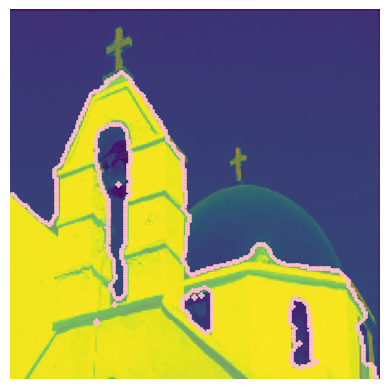

In [ ]:
plt.imshow(regions)
plt.imshow(I, alpha=.6)
plt.scatter(contours[:,1], contours[:,0], c="pink", s=1)
plt.axis("off")
plt.show()

### Save video + frames

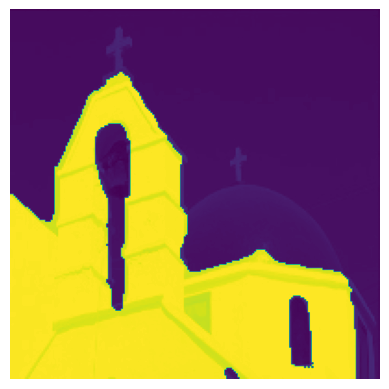

In [ ]:
plt.imshow(video_seq[-1])
plt.axis('off')
plt.savefig("./presentation/images/mosquee_last_frame_merge_circles.png", dpi=300)
plt.show()

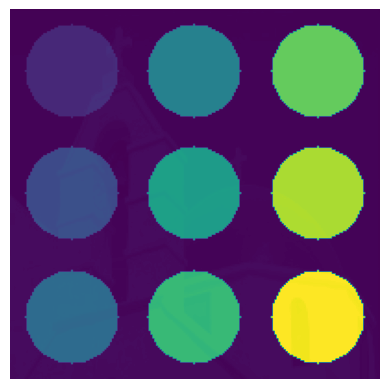

In [ ]:
plt.imshow(video_seq[0])
plt.axis('off')
plt.savefig("./presentation/images/mosquee_first_frame_merge_circles.png", dpi=300)
plt.show()

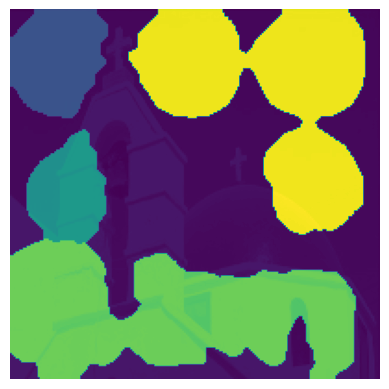

In [ ]:
plt.imshow(video_seq[15])
plt.axis('off')
plt.savefig("./presentation/images/mosquee_middle_frame_merge_circles.png", dpi=300)
plt.show()

In [ ]:
fourcc = cv2.VideoWriter_fourcc(*"MP4V")
fps = 5
height, width = I.shape

video_writer = cv2.VideoWriter('./presentation/videos/mosquee_success_merge_circles.mp4',
                               fourcc,
                               fps,
                               (width, height))

for im in video_seq:
  im_new = im*255.
  im_new = cv2.cvtColor(im_new.astype('uint8'), cv2.COLOR_GRAY2BGR)
  video_writer.write(im_new)

video_writer.release()